In [1]:
import torch
import pathlib
import cv2
import numpy as np
import matplotlib.pyplot as plt
from vit_pytorch import ViT
from models.binae import BinModel
from einops import rearrange

## Specify the configurations that you want to use to build your model

Here, pick the desired configuration depending on the weights that you downloaded from our repository. The weights can be downloaded from; https://github.com/dali92002/DocEnTR in the Section Model Zoo.

In [2]:

THRESHOLD = 0.5 ## binarization threshold after the model output

SPLITSIZE =  256  ## your image will be divided into patches of 256x256 pixels
setting = "base"  ## choose the desired model size [small, base or large], depending on the model you want to use
patch_size = 8 ## choose your desired patch size [8 or 16], depending on the model you want to use
image_size =  (SPLITSIZE,SPLITSIZE)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
if setting == 'base':
    encoder_layers = 6
    encoder_heads = 8
    encoder_dim = 768

if setting == 'small':
    encoder_layers = 3
    encoder_heads = 4
    encoder_dim = 512

if setting == 'large':
    encoder_layers = 12
    encoder_heads = 16
    encoder_dim = 1024

## Build your model
Build the transformer autoencoder model

In [5]:
v = ViT(
    image_size = image_size,
    patch_size = patch_size,
    num_classes = 1000,
    dim = encoder_dim,
    depth = encoder_layers,
    heads = encoder_heads,
    mlp_dim = 2048
)
model = BinModel(
    encoder = v,
    decoder_dim = encoder_dim,      
    decoder_depth = encoder_layers,
    decoder_heads = encoder_heads       
)

model = model.to(device)

## load the pretrained weights that were downloaded from our repo:
Here, give the path of the downloaded weights and load them to use a trained model.

In [6]:
model_path = "./weights/best-model_8_2018base_256_8.pt"
model.load_state_dict(torch.load(model_path, map_location=device))

<All keys matched successfully>

## Read the degraded image

Here specify the location of the degraded image that you want to clean. and then read it. We also can visualize it before cleaning. Here I have a folder named demo that contain two folders named degraded and cleaned, the degraded contain the degraded image and the cleaned will contain later the obtained results. But you can specify your own names of folders.

In [7]:
deg_folder = './demo/degraded/'
image_name = '2.png'
deg_image = cv2.imread(deg_folder+image_name) / 255

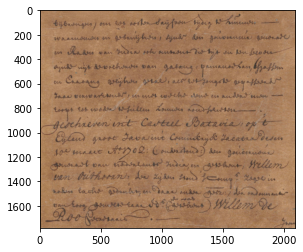

In [8]:
plt.imshow(deg_image[:, :, [2, 1, 0]]) # Show image 

## Split and Merge functions

Here, two function that are used for splitting an image into patches and merge a list of patches into an image. 

In [9]:
def split(im,h,w):
    patches=[]
    nsize1=SPLITSIZE
    nsize2=SPLITSIZE
    for ii in range(0,h,nsize1): #2048
        for iii in range(0,w,nsize2): #1536
            patches.append(im[ii:ii+nsize1,iii:iii+nsize2,:])
    
    return patches 

def merge_image(splitted_images, h,w):
    image=np.zeros(((h,w,3)))
    nsize1=SPLITSIZE
    nsize2=SPLITSIZE
    ind =0
    for ii in range(0,h,nsize1):
        for iii in range(0,w,nsize2):
            image[ii:ii+nsize1,iii:iii+nsize2,:]=splitted_images[ind]
            ind += 1
    return image  


## Preprocess the Image

Preprocess the image by dividing it into patches and get them ready to be used by the model

In [10]:
## Split the image intop patches, an image is padded first to make it dividable by the split size
h =  ((deg_image.shape[0] // 256) +1)*256 
w =  ((deg_image.shape[1] // 256 ) +1)*256
deg_image_padded=np.ones((h,w,3))
deg_image_padded[:deg_image.shape[0],:deg_image.shape[1],:]= deg_image
patches = split(deg_image_padded, deg_image.shape[0], deg_image.shape[1])

In [11]:
## preprocess the patches (images)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

out_patches=[]
for p in patches:
    out_patch = np.zeros([3, *p.shape[:-1]])
    for i in range(3):
        out_patch[i] = (p[:,:,i] - mean[i]) / std[i]
    out_patches.append(out_patch)

## Clean your image with the trained model

Clean your list of patches obe by one.

In [12]:
result = []
for patch_idx, p in enumerate(out_patches):
    print(f"({patch_idx} / {len(out_patches) - 1}) processing patch...")
    p = np.array(p, dtype='float32')
    train_in = torch.from_numpy(p)

    with torch.no_grad():
        train_in = train_in.view(1,3,SPLITSIZE,SPLITSIZE).to(device)
        _ = torch.rand((train_in.shape)).to(device)
        loss,_, pred_pixel_values = model(train_in,_)
        rec_patches = pred_pixel_values
        rec_image = torch.squeeze(rearrange(rec_patches, 'b (h w) (p1 p2 c) -> b c (h p1) (w p2)', p1 = patch_size, p2 = patch_size,  h=image_size[0]//patch_size))
        impred = rec_image.cpu().numpy()
        impred = np.transpose(impred, (1, 2, 0))
        for ch in range(3):
            impred[:,:,ch] = (impred[:,:,ch] *std[ch]) + mean[ch]
        impred[np.where(impred>1)] = 1
        impred[np.where(impred<0)] = 0
    result.append(impred)

(0 / 62) processing patch...
(1 / 62) processing patch...
(2 / 62) processing patch...
(3 / 62) processing patch...
(4 / 62) processing patch...
(5 / 62) processing patch...
(6 / 62) processing patch...
(7 / 62) processing patch...
(8 / 62) processing patch...
(9 / 62) processing patch...
(10 / 62) processing patch...
(11 / 62) processing patch...
(12 / 62) processing patch...
(13 / 62) processing patch...
(14 / 62) processing patch...
(15 / 62) processing patch...
(16 / 62) processing patch...
(17 / 62) processing patch...
(18 / 62) processing patch...
(19 / 62) processing patch...
(20 / 62) processing patch...
(21 / 62) processing patch...
(22 / 62) processing patch...
(23 / 62) processing patch...
(24 / 62) processing patch...
(25 / 62) processing patch...
(26 / 62) processing patch...
(27 / 62) processing patch...
(28 / 62) processing patch...
(29 / 62) processing patch...
(30 / 62) processing patch...
(31 / 62) processing patch...
(32 / 62) processing patch...
(33 / 62) processing

## Get your cleaned image and save it

After cleaning the list of patches you can now merge them again to an image ang get it back to it original size by removing the padding. Here you can also vizualize your image before saving it into your desired folder.

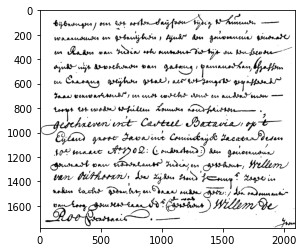

In [13]:
clean_image = merge_image(result, deg_image_padded.shape[0], deg_image_padded.shape[1])
clean_image = clean_image[:deg_image.shape[0], :deg_image.shape[1],:]
clean_image = (clean_image>THRESHOLD)*255
plt.imshow(clean_image)

In [14]:
output_dir = pathlib.Path('./demo/cleaned')
output_dir.mkdir(exist_ok=True)

model_name = pathlib.Path(model_path).stem
image_path = pathlib.Path(image_name)
output_path = output_dir.joinpath(f'{image_path.stem}__{model_name}{image_path.suffix}')

cv2.imwrite(str(output_path), clean_image)
print(f'created file: {output_path}')

created file: demo/cleaned/2__best-model_8_2018base_256_8.png
